### $\color{purple}{\text{Projet : Prévision de la Demande d'Articles de Pêche et de Camping avec des Réseaux de Neurones Profonds}}$

## $\color{lightpink}{\text{Réalisé par : Chaima HAMMAMI - Kmar MEZGHANI}}$

### $\color{violet}{\text{1. Description du projet}}$

Ce projet vise à développer un modèle de prévision de la demande pour des articles spécifiques tels que les articles de pêche et de camping. La demande pour ces articles est influencée par des facteurs comme les phases lunaires et les vacances. Les périodes de pêche intensive, déterminées par des phases lunaires favorables, et les vacances, où les activités de plein air augmentent, sont des moments clés où la demande s'élève.

### $\color{violet}{\text{2. Objectif}}$

L'objectif est de créer des modèles de prévision de la demande en utilisant des réseaux de neurones profonds, spécifiquement des LSTM (Long Short-Term Memory), des RNN (Recurrent Neural Networks), et des GRU (Gated Recurrent Unit) multivariés. Ces modèles intégreront des données historiques de demande, les phases de la lune et les jours de fête nationales.

### $\color{violet}{\text{3. Étapes du Projet}}$

### $\color{lightblue}{\text{3.1. Préparation des données historiques de la demande :}}$

In [ ]:
import pandas as pd

# Load the Excel file
file_path = 'data_project4.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows
data.head()


,Row ID,Order ID,Order Date,Product ID,Category,Quantity
0,32298,CA-2012-124891,2020-08-01,TEC-AC-10003033,C1,7
1,26341,IN-2013-77878,2021-02-06,FUR-CH-10003950,C2,9
2,25330,IN-2013-71249,2021-10-18,TEC-PH-10004664,C1,9
3,13524,ES-2013-1579342,2021-01-29,TEC-PH-10004583,C1,5
4,47221,SG-2013-4320,2021-11-06,TEC-SHA-10000501,C1,8


In [ ]:
# Convert 'Order Date' to datetime format
data['Order Date'] = pd.to_datetime(data['Order Date'])

# Display the first few rows to verify the conversion
data.head()


,Row ID,Order ID,Order Date,Product ID,Category,Quantity
0,32298,CA-2012-124891,2020-08-01,TEC-AC-10003033,C1,7
1,26341,IN-2013-77878,2021-02-06,FUR-CH-10003950,C2,9
2,25330,IN-2013-71249,2021-10-18,TEC-PH-10004664,C1,9
3,13524,ES-2013-1579342,2021-01-29,TEC-PH-10004583,C1,5
4,47221,SG-2013-4320,2021-11-06,TEC-SHA-10000501,C1,8


### $\color{lightblue}{\text{3.2. Génération des phases de la Lune}}$

In [ ]:
pip install ephem

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import ephem
import datetime

In [ ]:
import ephem

def get_moon_phase(date):
    moon = ephem.Moon(date)
    phase = moon.phase
    if phase < 7.38 or phase > 352.62:
        return 'New Moon'
    elif 7.38 <= phase < 22.14:
        return 'Waxing Crescent'
    elif 22.14 <= phase < 37.38:
        return 'First Quarter'
    elif 37.38 <= phase < 52.62:
        return 'Waxing Gibbous'
    elif 52.62 <= phase < 67.38:
        return 'Full Moon'
    elif 67.38 <= phase < 82.62:
        return 'Waning Gibbous'
    elif 82.62 <= phase < 97.38:
        return 'Last Quarter'
    elif 97.38 <= phase < 112.62:
        return 'Waning Crescent'
    return 'Unknown'

# Generate lunar phases for all unique dates in the data
unique_dates = data['Order Date'].unique()
moon_phases = {date: get_moon_phase(date) for date in unique_dates}

# Map the lunar phases to the original dataframe
data['Moon Phase'] = data['Order Date'].map(moon_phases)

# Display the first few rows to verify the lunar phase addition
data.head()


,Row ID,Order ID,Order Date,Product ID,Category,Quantity,Moon Phase
0,32298,CA-2012-124891,2020-08-01,TEC-AC-10003033,C1,7,Waxing Crescent
1,26341,IN-2013-77878,2021-02-06,FUR-CH-10003950,C2,9,Waxing Gibbous
2,25330,IN-2013-71249,2021-10-18,TEC-PH-10004664,C1,9,Waning Gibbous
3,13524,ES-2013-1579342,2021-01-29,TEC-PH-10004583,C1,5,Waxing Crescent
4,47221,SG-2013-4320,2021-11-06,TEC-SHA-10000501,C1,8,New Moon


### $\color{lightblue}{\text{3.3. Génération des jours de fête nationales :}}$

In [ ]:
pip install holidays

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import holidays

# Define the years for which to generate holidays
years = range(data['Order Date'].dt.year.min(), data['Order Date'].dt.year.max() + 1)

# Generate public holidays for Tunisia
tunisia_holidays = holidays.TN(years=years)

# Create a dataframe with holiday information
holiday_list = [{'date': date, 'holiday': name} for date, name in tunisia_holidays.items()]
holidays_df = pd.DataFrame(holiday_list)

# Fusionner les jours fériés avec les données de vente
data['is_holiday'] = data['Order Date'].isin(holidays_df['date'])

# Afficher les premières lignes pour vérifier l'ajout des informations de jours fériés
data.head()


,Row ID,Order ID,Order Date,Product ID,Category,Quantity,Moon Phase,is_holiday
0,32298,CA-2012-124891,2020-08-01,TEC-AC-10003033,C1,7,Waxing Crescent,True
1,26341,IN-2013-77878,2021-02-06,FUR-CH-10003950,C2,9,Waxing Gibbous,False
2,25330,IN-2013-71249,2021-10-18,TEC-PH-10004664,C1,9,Waning Gibbous,True
3,13524,ES-2013-1579342,2021-01-29,TEC-PH-10004583,C1,5,Waxing Crescent,False
4,47221,SG-2013-4320,2021-11-06,TEC-SHA-10000501,C1,8,New Moon,False


### $\color{lightblue}{\text{3.4. Intégration des nouvelles variables dans les données de demande :}}$

In [ ]:
# Afficher les types de données pour s'assurer que tout est correct
print(data.dtypes)

# Vérifier les données fusionnées
print(data.head())

# Enregistrer les données fusionnées dans un nouveau fichier Excel si nécessaire
output_file_path = 'data_with_moon_phases_and_holidays.xlsx'
data.to_excel(output_file_path, index=False)
print(f"Les données fusionnées ont été enregistrées dans {output_file_path}")


Row ID                 int64
Order ID              object
Order Date    datetime64[ns]
Product ID            object
Category              object
Quantity               int64
Moon Phase            object
is_holiday              bool
dtype: object
   Row ID         Order ID Order Date        Product ID Category  Quantity  \
0   32298   CA-2012-124891 2020-08-01   TEC-AC-10003033       C1         7   
1   26341    IN-2013-77878 2021-02-06   FUR-CH-10003950       C2         9   
2   25330    IN-2013-71249 2021-10-18   TEC-PH-10004664       C1         9   
3   13524  ES-2013-1579342 2021-01-29   TEC-PH-10004583       C1         5   
4   47221     SG-2013-4320 2021-11-06  TEC-SHA-10000501       C1         8   

        Moon Phase  is_holiday  
0  Waxing Crescent        True  
1   Waxing Gibbous       False  
2   Waning Gibbous        True  
3  Waxing Crescent       False  
4         New Moon       False  
Les données fusionnées ont été enregistrées dans data_with_moon_phases_and_holidays.xls

### $\color{lightblue}{\text{3.5. Préparation des données pour chaque modèle (LSTM, RNN, GRU) :}}$

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# Sélectionner les colonnes pertinentes
data = data[['Order Date', 'Quantity', 'Moon Phase', 'is_holiday']]

# Convertir les phases de la lune en variables numériques
moon_phase_mapping = {
    'New Moon': 0,
    'Waxing Crescent': 1,
    'First Quarter': 2,
    'Waxing Gibbous': 3,
    'Full Moon': 4,
    'Waning Gibbous': 5,
    'Last Quarter': 6,
    'Waning Crescent': 7
}
data['Moon Phase'] = data['Moon Phase'].map(moon_phase_mapping)

# Remplacer les NaN dans 'Moon Phase' par 0 (si nécessaire)
data['Moon Phase'].fillna(0, inplace=True)

# Convertir 'is_holiday' en int
data['is_holiday'] = data['is_holiday'].astype(int)

# Normaliser les données
scaler = MinMaxScaler()
data[['Quantity', 'Moon Phase', 'is_holiday']] = scaler.fit_transform(data[['Quantity', 'Moon Phase', 'is_holiday']])

# Afficher les premières lignes pour vérifier
print(data.head())

# Préparer les séquences pour les modèles
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length]
        target = data.iloc[i + sequence_length]['Quantity']
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Drop the 'Order Date' column from the data before creating sequences hedhi li zedtha
data = data.drop(columns=['Order Date'])


sequence_length = 30  # Par exemple, utiliser les 30 jours précédents pour prédire le jour suivant
X, y = create_sequences(data, sequence_length)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Afficher les formes des ensembles d'entraînement et de test
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


  Order Date  Quantity  Moon Phase  is_holiday
0 2020-08-01  0.461538         0.0         1.0
1 2021-02-06  0.615385         0.0         0.0
2 2021-10-18  0.615385         0.0         1.0
3 2021-01-29  0.307692         0.0         0.0
4 2021-11-06  0.538462         0.0         0.0
(40958, 30, 3) (10240, 30, 3) (40958,) (10240,)


### $\color{lightblue}{\text{3.6. Entraînement des modèles :}}$

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU, Dense

# Fonction pour créer un modèle
def create_model(model_type, input_shape):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(50, activation='tanh', input_shape=input_shape))
    elif model_type == 'RNN':
        model.add(SimpleRNN(50, activation='tanh', input_shape=input_shape))
    elif model_type == 'GRU':
        model.add(GRU(50, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model




In [ ]:
import numpy as np

def train_model(model_type, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = create_model(model_type, input_shape)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f'{model_type} Model Loss: {loss}')
    return model, history



# Entraîner les modèles LSTM, RNN et GRU
lstm_model, lstm_history = train_model('LSTM', X_train, y_train, X_test, y_test)
rnn_model, rnn_history = train_model('RNN', X_train, y_train, X_test, y_test)
gru_model, gru_history = train_model('GRU', X_train, y_train, X_test, y_test)


Epoch 1/50


C:\Users\LENOVO\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0305 - val_loss: 0.0273
Epoch 2/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0276 - val_loss: 0.0272
Epoch 3/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0279 - val_loss: 0.0270
Epoch 4/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0275 - val_loss: 0.0270
Epoch 5/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0274 - val_loss: 0.0271
Epoch 6/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0275 - val_loss: 0.0271
Epoch 7/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0278 - val_loss: 0.0270
Epoch 8/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0275 - val_loss: 0.0269
Epoch 9/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0273 - val_loss: 0.0274
Epoch 10/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0274 - val_loss: 0.0268
Epoch 11/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0276 - val_loss: 0.0268
Epoch 12/50
1024/1024 ━━━━━━━━━━━━━━━━━━━

1024/1024 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0274 - val_loss: 0.0269
Epoch 34/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0265 - val_loss: 0.0270
Epoch 35/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0273 - val_loss: 0.0268
Epoch 36/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0279 - val_loss: 0.0268
Epoch 37/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0272 - val_loss: 0.0267
Epoch 38/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0270 - val_loss: 0.0267
Epoch 39/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0275 - val_loss: 0.0268
Epoch 40/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0268 - val_loss: 0.0267
Epoch 41/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0264 - val_loss: 0.0268
Epoch 42/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0268 - val_loss: 0.0269
Epoch 43/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0272 - val_loss: 0.0267
Epoch 44/50
1024/1024 ━━━━━━━━━━━

### $\color{lightblue}{\text{3.7. Application de la prévision sur le sous-ensemble de test :}}$

In [ ]:
# Faire des prédictions sur le sous-ensemble de test
y_pred_lstm = lstm_model.predict(X_test)
y_pred_rnn = rnn_model.predict(X_test)
y_pred_gru = gru_model.predict(X_test)

320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


### $\color{lightblue}{\text{3.8. Analyse des performances statistiques appropriées :}}$

LSTM - MSE: 0.02665893977081647, MAE: 0.12322938231171485, RMSE: 0.1632756557813089, MAPE: 112489579842765.33
RNN - MSE: 0.026968900594325985, MAE: 0.1259668441587844, RMSE: 0.1642221075078687, MAPE: 125682519094067.72
GRU - MSE: 0.02661935129471597, MAE: 0.12400795316053308, RMSE: 0.1631543787175691, MAPE: 115310039307059.75


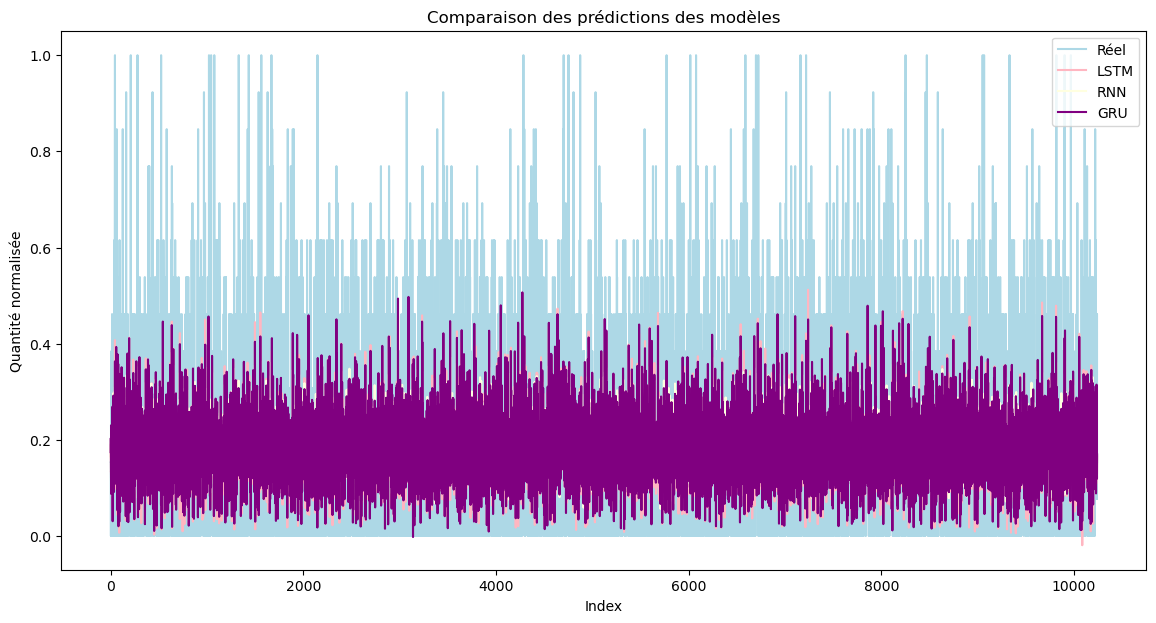

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
# Fonction pour évaluer les modèles
def evaluate_model(y_test, y_pred, model_name):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f'{model_name} - MSE: {mse}, MAE: {mae}, RMSE: {rmse}')
    return mse, mae, rmse

# Évaluer les modèles
mse_lstm, mae_lstm, rmse_lstm = evaluate_model(y_test, y_pred_lstm, 'LSTM')
mse_rnn, mae_rnn, rmse_rnn = evaluate_model(y_test, y_pred_rnn, 'RNN')
mse_gru, mae_gru, rmse_gru = evaluate_model(y_test, y_pred_gru, 'GRU')

# Visualiser les résultats
plt.figure(figsize=(14, 7))

# Tracer les valeurs réelles
plt.plot(y_test, label='Réel', color='lightblue')

# Tracer les valeurs prédites par LSTM
plt.plot(y_pred_lstm, label='LSTM', color='lightpink')

# Tracer les valeurs prédites par RNN
plt.plot(y_pred_rnn, label='RNN', color='lightyellow')

# Tracer les valeurs prédites par GRU
plt.plot(y_pred_gru, label='GRU', color='purple')

# Ajouter des légendes et des titres
plt.title('Comparaison des prédictions des modèles')
plt.xlabel('Index')
plt.ylabel('Quantité normalisée')
plt.legend()
plt.show()



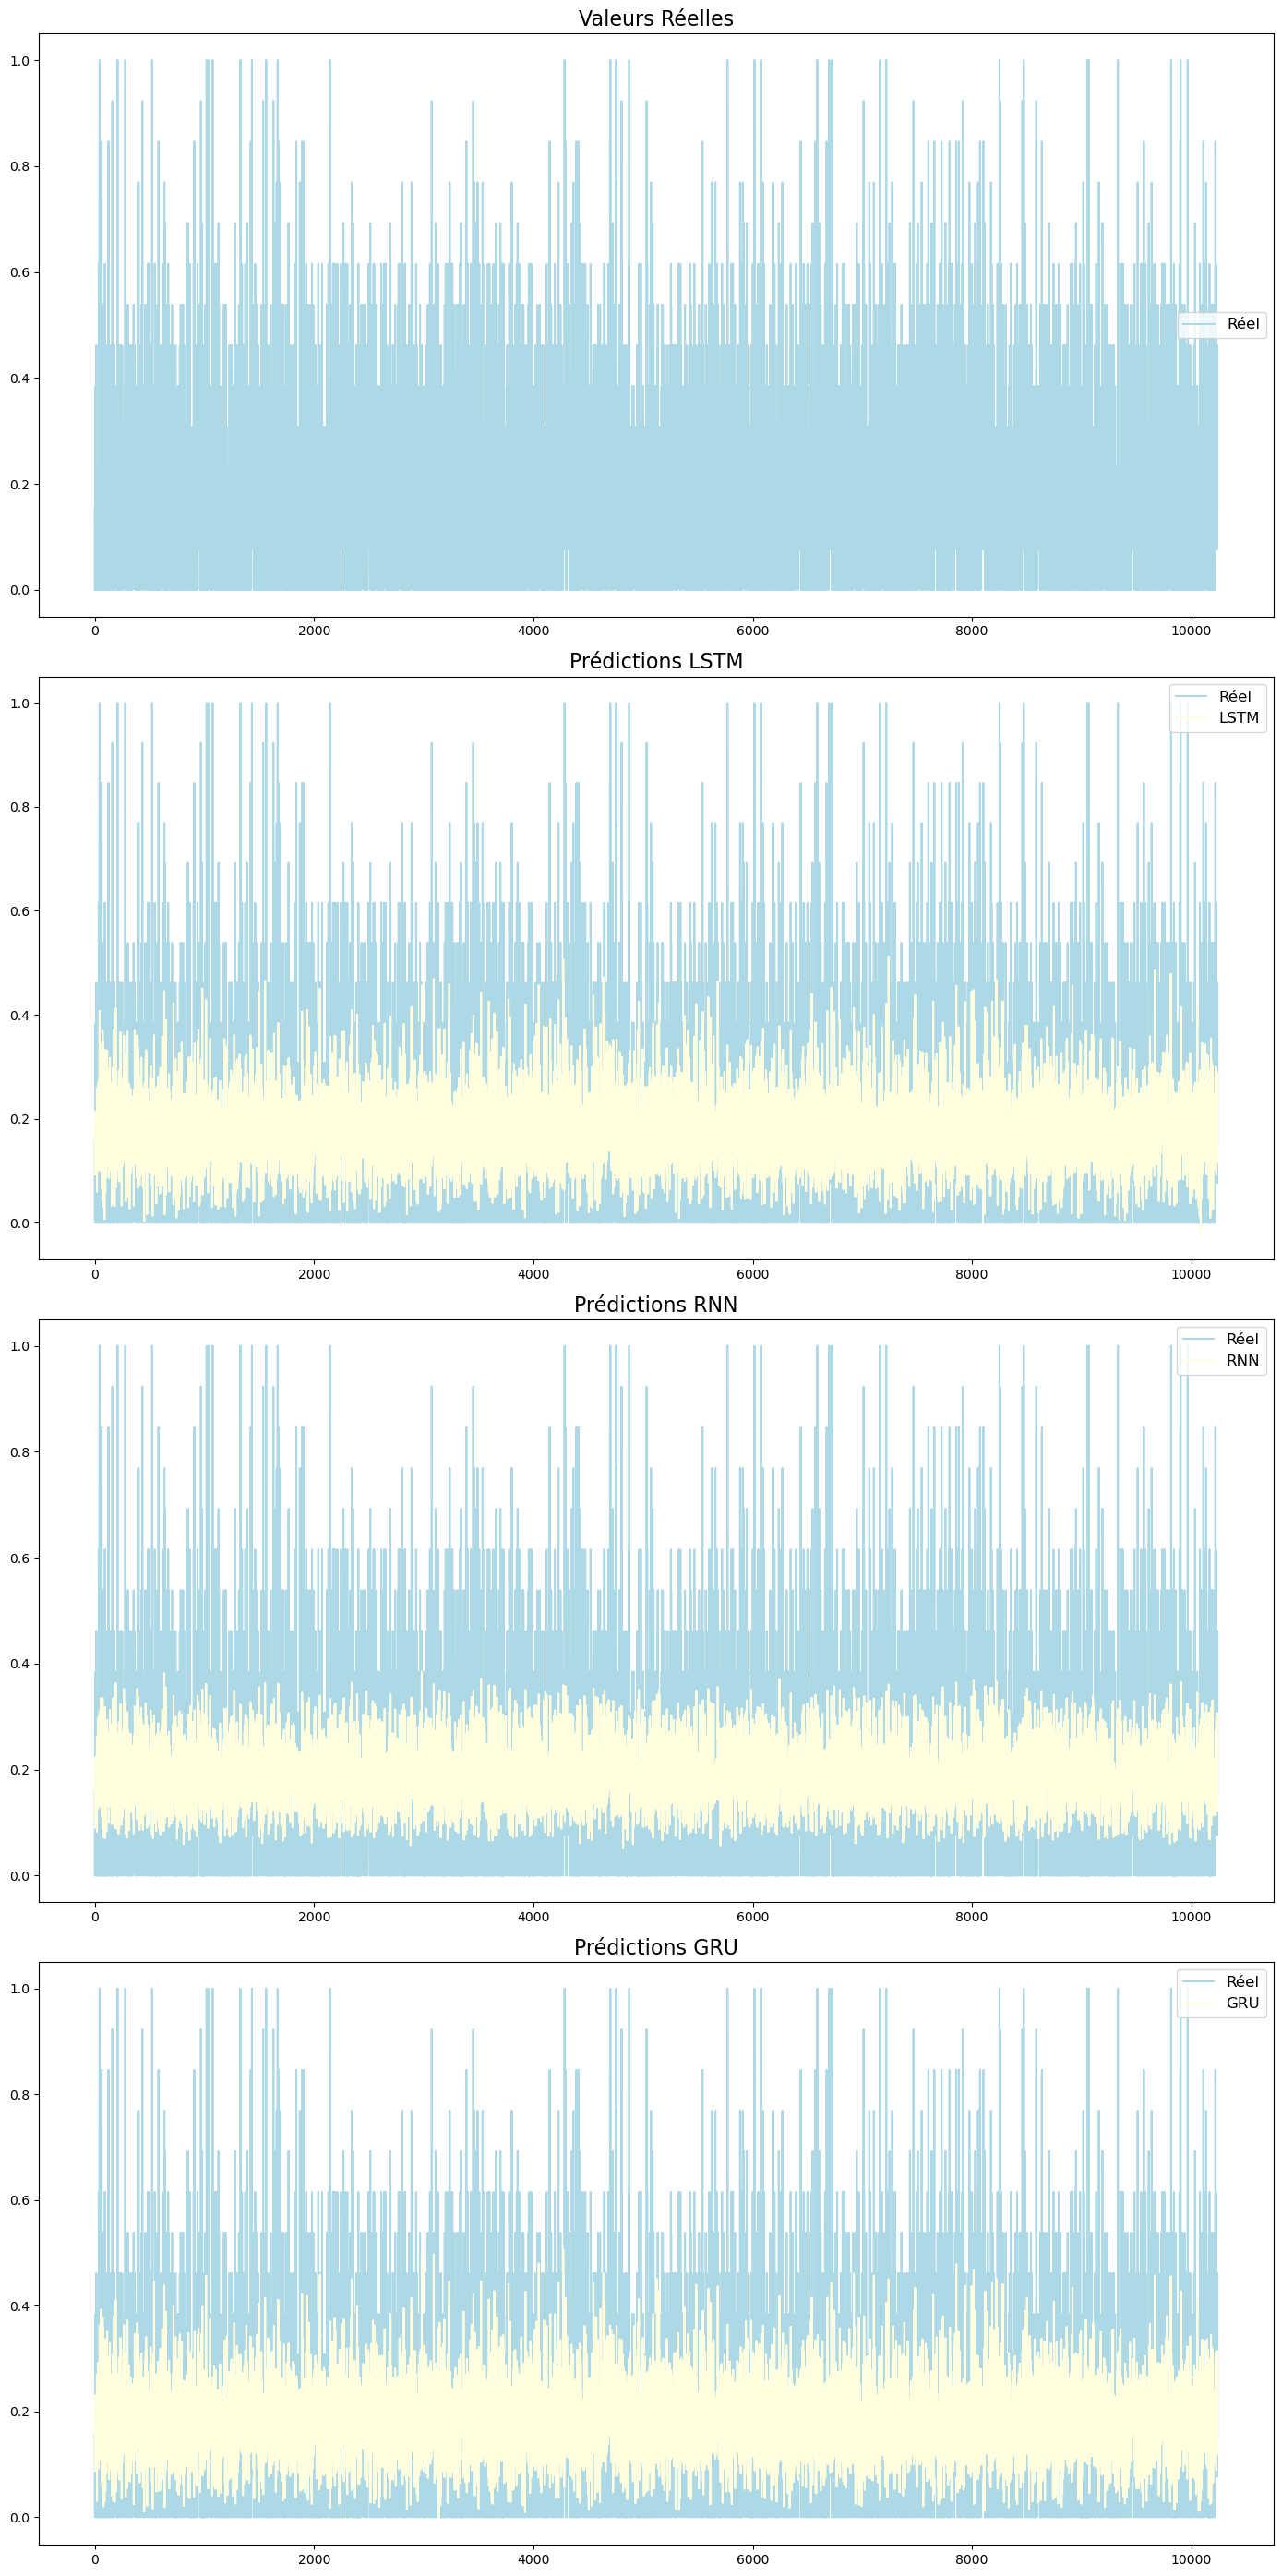

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with four subplots
fig, axs = plt.subplots(4, 1, figsize=(14, 28))

# Plot real values on each subplot
axs[0].plot(y_test, label='Réel', color='lightblue')
axs[0].set_title('Valeurs Réelles', fontsize=16)
axs[0].legend(fontsize=12)

# Plot LSTM predictions on second subplot
axs[1].plot(y_test, label='Réel', color='lightblue')
axs[1].plot(y_pred_lstm, label='LSTM', color='lightyellow')
axs[1].set_title('Prédictions LSTM', fontsize=16)
axs[1].legend(fontsize=12)

# Plot RNN predictions on third subplot
axs[2].plot(y_test, label='Réel', color='lightblue')
axs[2].plot(y_pred_rnn, label='RNN', color='lightyellow')
axs[2].set_title('Prédictions RNN', fontsize=16)
axs[2].legend(fontsize=12)

# Plot GRU predictions on fourth subplot
axs[3].plot(y_test, label='Réel', color='lightblue')
axs[3].plot(y_pred_gru, label='GRU', color='lightyellow')
axs[3].set_title('Prédictions GRU', fontsize=16)
axs[3].legend(fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


### $\color{violet}{\text{4. Explication des architectures deep learning proposées}}$


Pour ce projet, trois architectures principales de réseaux de neurones profonds seront utilisées : LSTM, RNN et GRU. Chacune de ces architectures est adaptée pour traiter des séries temporelles et peut capturer les dépendances à long terme présentes dans les données de demande historique, les phases de la lune et les jours de fête nationales.

#### $\color{gray}{\text{1. LSTM (Long Short-Term Memory)}}$

Les LSTM sont des réseaux de neurones récurrents conçus pour surmonter les problèmes de gradient (explosion ou disparition) des RNN traditionnels.
Ils possèdent des cellules de mémoire capables de retenir des informations pendant de longues périodes.

Les LSTM sont utilisés pour deaux raisons intéressantes:

* Capture des dépendances à long terme : Les LSTM sont particulièrement efficaces pour capturer les relations temporelles à long terme, ce qui est essentiel pour prévoir des variations saisonnières et cycliques dans les données de demande.

* Robustesse : Ils sont robustes face aux problèmes de vanishing gradient, ce qui les rend performants pour des séries temporelles avec des fluctuations sur de longues périodes.

#### $\color{gray}{\text{2. RNN (Recurrent Neural Network)}}$

Les RNN sont des réseaux de neurones qui utilisent des connexions récurrentes pour traiter des séquences de données.
Ils possèdent des boucles internes permettant de conserver une mémoire des états précédents, ce qui est utile pour traiter des données séquentielles.

Les RNN sont utilisés pour deaux raisons intéressantes:

* Simplicité : Les RNN ont une architecture plus simple et sont plus faciles à implémenter et à entraîner.
* Adaptation rapide : Pour des séries temporelles avec des dépendances à court terme, les RNN peuvent être suffisants et plus rapides à entraîner que les LSTM ou GRU.

#### $\color{gray}{\text{3. GRU (Gated Recurrent Unit)}}$

Les GRU sont une variante simplifiée des LSTM avec seulement deux portes (mise à jour et réinitialisation).
Ils sont conçus pour combiner les avantages des LSTM tout en étant moins complexes et plus rapides à entraîner.

Les GRU sont utilisés pour deaux raisons intéressantes:
* Efficacité computationnelle : Les GRU sont moins complexes que les LSTM et nécessitent moins de ressources computationnelles.
* Performances similaires aux LSTM : Pour de nombreuses applications, les GRU offrent des performances comparables aux LSTM tout en étant plus rapides.

### $\color{violet}{\text{5. Justification des choix des indicateurs de performance}}$


Pour évaluer la performance des modèles, les indicateurs suivants seront utilisés :

#### $\color{gray}{\text{1. RMSE (Root Mean Square Error)}}$

La RMSE mesure l'écart-type des résidus (erreurs de prédiction).
Elle pénalise fortement les grandes erreurs.

On l'utilise pour ces raisons:

* Sensibilité aux grandes erreurs : Comme les grandes erreurs peuvent être critiques dans la prévision de la demande, la RMSE permet de les identifier et de les corriger.
* Interprétabilité : Elle est facilement interprétable et donne une idée directe de l’erreur moyenne des prédictions en unités de la variable cible.

#### $\color{gray}{\text{2. MAE (Mean Absolute Error)}}$

La MAE mesure la moyenne des erreurs absolues entre les valeurs prévues et observées.

On l'utilise pour ces raisons:

* Robustesse : La MAE est moins sensible aux grandes erreurs que la RMSE et fournit une mesure plus robuste de la performance.
* Interprétabilité : Elle est simple à comprendre et à interpréter, donnant une idée claire de l'erreur moyenne des prédictions.

#### $\color{gray}{\text{3. MAPE (Mean Absolute Percentage Error)}}$

La MAPE mesure l'erreur absolue moyenne en pourcentage des valeurs observées.

On l'utilise pour ces raisons:
* Échelle relative : La MAPE est utile pour comprendre l'erreur en termes relatifs, ce qui est pratique pour des données de demande qui peuvent varier en amplitude.
* Comparaison des performances : Elle permet de comparer la performance des modèles sur des séries temporelles de différentes échelles.

### $\color{violet}{\text{5. Conclusion}}$


En utilisant les architectures LSTM, RNN et GRU, nous capturons à la fois les dépendances à court et à long terme dans les données. Les indicateurs de performance RMSE, MAE  offrent une vue complète des performances des modèles, prenant en compte à la fois les erreurs absolues et relatives, et mettant en évidence les grandes erreurs de prédiction.